# Kupffer Analysis Data Processing

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df

# Preprocessing

In [3]:
workingDirectory = '/home/h1bennet/liverStrains/results/181009_kupffer_ly6c_tba/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

## ATAC QC
requires tag directories

In [3]:
%%bash
if [ ! -d ./qc_atac/ ]; then mkdir ./qc_atac; fi

In [4]:
atac_qc = ngs_qc('./tag_directories_atac', 'atac')

NotADirectoryError: [Errno 20] Not a directory: './tag_directories_atac/._.DS_Store/'

## Create Script To Process ATAC tag directories


In [12]:
# renaming dict to make naming more consistant
rename_dict = {
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS': 'ncorwt_kupffertim4neg_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS': 'ncorwt_kupffertim4neg_nashdiet_21wk_2',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS': 'ncorwt_kupffertim4pos_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS': 'ncorwt_kupffertim4pos_nashdiet_21wk_2',
    'C57B6J_BloodLy6cHi3_ATAC_NoTx_MS_20171119': 'ncorwt_bloodly6chi_controldiet_0wk_1',
    'C57B6J_BloodLy6cHi8_ATAC_NoTx_MS_20171119': 'ncorwt_bloodly6chi_controldiet_0wk_2',
    'C57BL6J_M_BloodLy6CHiMono_ATAC_20wkNASHDiet_rep1_JSSTDT_20180815': 'ncorwt_bloodly6chi_nashdiet_20wk_1',
    'C57BL6J_M_BloodLy6cHiMono_ATAC_20wkNASHDiet_rep2_JSSTDT_20180815': 'ncorwt_bloodly6chi_nashdiet_20wk_2',
    'C57BL6J_M_BloodLy6CLowMono_ATAC_20wkNASHDiet_rep1_JSSTDT_20180815': 'ncorwt_bloodly6clo_nashdiet_20wk_1',
    'C57BL6J_M_BloodLy6cLowMono_ATAC_20wkNASHDiet_rep2_JSSTDT_20180815': 'ncorwt_bloodly6clo_nashdiet_20wk_2',
    'c57bl6j_M_Ly6Chigh_ATAC_AMLN30Wk_C573A_TDT_JSS_s20171012': 'ncorwt_liverly6chi_nashdiet_30wk_1',
    'c57bl6j_M_Ly6Chigh_ATAC_AMLN30Wk_C573B_TDT_JSS_s20171012': 'ncorwt_liverly6chi_nashdiet_30wk_2',
    'c57bl6j_M_Ly6Clow_ATAC_AMLN30Wk_C573A_TDT_JSS_s20171012': 'ncorwt_liverly6clo_nashdiet_30wk_1',
    'c57bl6j_M_Ly6Clow_ATAC_AMLN30Wk_C573B_TDT_JSS_s20171012': 'ncorwt_liverly6clo_nashdiet_30wk_2',
    'c57bl6_Kupffer_ATAC_pooled_CR_TDT_16_01_19': 'ncorwt_kupffer_controldiet_0wk_1',
    'mouse_C57B6J_M_KupfferTim4Pos_ATAC_NoTx_JSSTDT165225Frag_C57e_JSS_l20170916_TAAGGCGA_S126_L006_R1_001': 'ncorwt_kupffer_controldiet_0wk_2'
}

In [13]:
%%bash
# delete the existing script file
rm ./peakCalling_homer.sh
# create a script file
touch ./peakCalling_homer.sh

# if directories don't exist, create them
if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi

In [14]:
with open('./peakCalling_homer.sh', 'w') as f:
    for tagdir, rename in rename_dict.items():
        find_peaks_idr = ['findPeaks', './tag_directories_atac/' + tagdir,
                          '-L', '0', '-C', '0', '-fdr', '0.9', '-style',
                          'factor', '-size', '200', '>',
                          workingDirectory + '/atac_peak_files/' + rename + '_peaks.tsv',
                          '&', '\n']
        find_peaks = ['findPeaks', './tag_directories_atac/' + tagdir,
                      '-style', 'factor', '-size', '200', '>',
                      workingDirectory + '/atac_peak_files/' + rename + '_default_peaks.tsv',
                      '&', '\n']
        # write commands to file
        f.write(' '.join(find_peaks_idr))
        f.write(' '.join(find_peaks))

### Run IDR 

In [15]:
%%bash
# delete the existing script file
rm ./run_idr.sh
# create a script file
touch ./run_idr.sh

# if directories don't exist, create them
if [ ! -d ./atac_idr/ ]; then mkdir ./atac_idr; fi

In [16]:
mylist = list(rename_dict.values())
mylist.sort()

In [17]:
import itertools
mylist = list(rename_dict.values())
mylist.sort()
with open('./run_idr.sh', 'w') as f:
    for i, j in itertools.combinations(mylist, r=2):
        run_idr = ['python', '/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                             workingDirectory + '/atac_peak_files/' + i + '_peaks.tsv',
                             workingDirectory + '/atac_peak_files/' + j + '_peaks.tsv',
                             './atac_idr/', '-threshold', '0.05', '&', '\n']
        if (i[:-2] == j[:-2]) & (i != j):
            f.write(' '.join(run_idr))

## ATAC TBA

#### Create script to run model

In [19]:
%%bash
# delete the existing script file
rm ./run_abtba.sh
# create a script file
touch ./run_abtba.sh

# if directories don't exist, create them
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
if [ ! -d ./background_files/ ]; then mkdir ./background_files; fi
if [ ! -d ./abtba_output/ ]; then mkdir ./abtba_output; fi

# for each peak file create several commands
for peak_file in ./atac_idr_peaks/*;

# generate name of bed file
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
# call Homer pos2bed.pl to create bed file
echo "pos2bed.pl $peak_file > $bed_file" >> ./run_abtba.sh

# generate peak sequence fasta file name
seq_file=${bed_file/peaks.bed/peaks.fasta};
seq_file=${seq_file/bed_files/peak_sequences};

# execute command to extract sequences
echo "/home/h1bennet/code/abtba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_abtba.sh

# generate background coordinates
echo "/home/h1bennet/code/abtba/model_training/generate_background_coordinates.py $bed_file mm10 ./background_files/">> ./run_abtba.sh

# rename background file
bg_seq_file=${seq_file/peak_sequences/background_files};
bg_seq_file=${bg_seq_file/peaks.fasta/background.fasta};
echo "mv ./background_files/background.fasta $bg_seq_file">> ./run_abtba.sh

# calculate motif scores for peaks and background
echo "/home/h1bennet/code/abtba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./abtba_output /home/h1bennet/code/abtba/default_motifs/*">> ./run_abtba.sh
combined_features=${seq_file/peak_sequences/abtba_output}
combined_features=${combined_features/.fasta/_features.tsv}
labels=${combined_features/features.tsv/labels.txt}
echo "mv ./abtba_output/combined_features.tsv $combined_features">> ./run_abtba.sh
echo "mv ./abtba_output/labels.txt $labels">> ./run_abtba.sh

# train classifier
echo "/home/h1bennet/code/abtba/model_training/train_classifier.py $combined_features $labels ./abtba_output/">> ./run_abtba.sh
coeff_path=${combined_features/features.tsv/coefficients.tsv}
performance_path=${combined_features/features.tsv/performance.tsv}
echo "mv ./abtba_output/coefficients.tsv $coeff_path">> ./run_abtba.sh
echo "mv ./abtba_output/performance.tsv $performance_path">> ./run_abtba.sh

# perform insilico mutagenesis
echo "/home/h1bennet/code/abtba/model_training/calc_feature_significance.py $combined_features $labels ./abtba_output/ -num_iterations 1">> ./run_abtba.sh
significance_path=${combined_features/features.tsv/significance.tsv}
echo mv ./abtba_output/significance.tsv $significance_path>> ./run_abtba.sh

done

### Run Homer Known Motif Analysis

In [ ]:
%%bash
# delete the existing script file
rm ./run_knownmotif.sh
# create a script file
touch ./run_knownmotif.sh

# if directories don't exist, create them
if [ ! -d ./known_motif/ ]; then mkdir ./known_motif; fi

for peak_file in ./atac_idr_peaks/*;

do motif_file=${peak_file/atac_idr_peaks.tsv/known_motif_enrichment}
motif_file=${motif_file/atac_idr_peaks/known_motif}
echo "findMotifsGenome.pl $peak_file mm10 $motif_file -size 200 -nomotif &" >> run_knownmotif.sh
done

# Plots

In [11]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

# define sample order for plotting
samp_order=['ncorwt_bloodly6chi_controldiet',
            'ncorwt_bloodly6clo_nashdiet',
            'ncorwt_bloodly6chi_nashdiet',
            'ncorwt_liverly6clo_nashdiet',
            'ncorwt_liverly6chi_nashdiet',
            'ncorwt_kupffer_controldiet',
            'ncorwt_kupffertim4neg_nashdiet',
            'ncorwt_kupffertim4pos_nashdiet']

### read in weight values

In [4]:
sample_weights_dict = {}
for f in os.listdir('./abtba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./abtba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:3])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [5]:
sample_pval_dict = {}
for f in os.listdir('./abtba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./abtba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:3])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


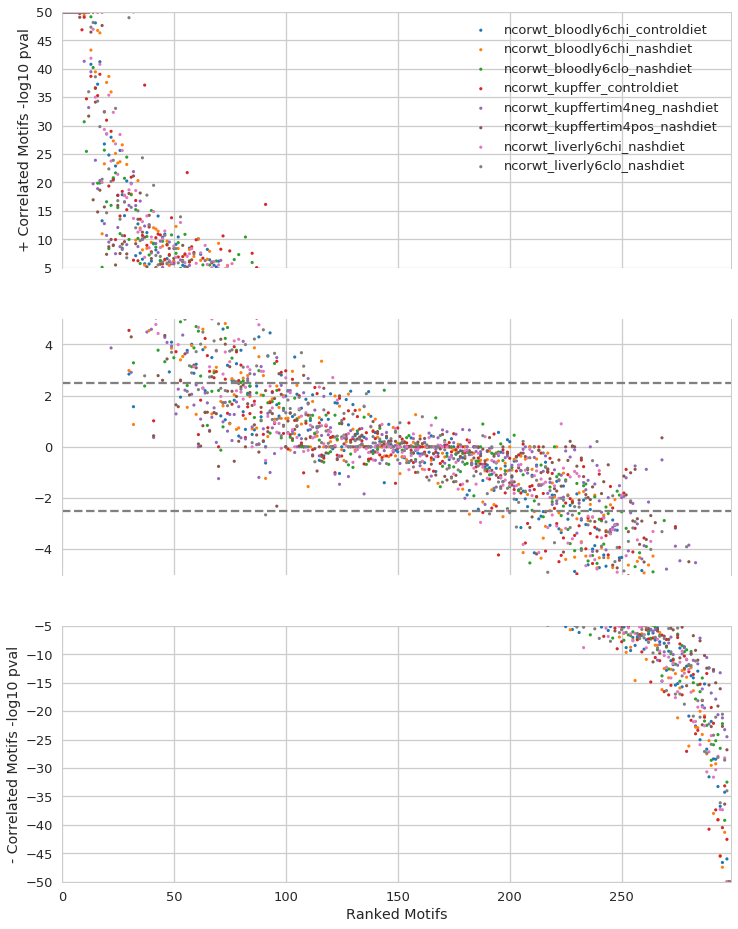

In [6]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,299)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=299,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=299,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')


### dict to rename rows with the motif sets

In [7]:
merged_motif_dict = {}

with open('/home/h1bennet/code/abtba/motif_metadata.tsv', 'r') as f:
    f.readline()
    for i in f.readlines():
        fields = i.split()
        if 'merged' in fields[0]:
            merged_motif_dict[fields[0]]=fields[1]

### Top 20 Average Motif Significance

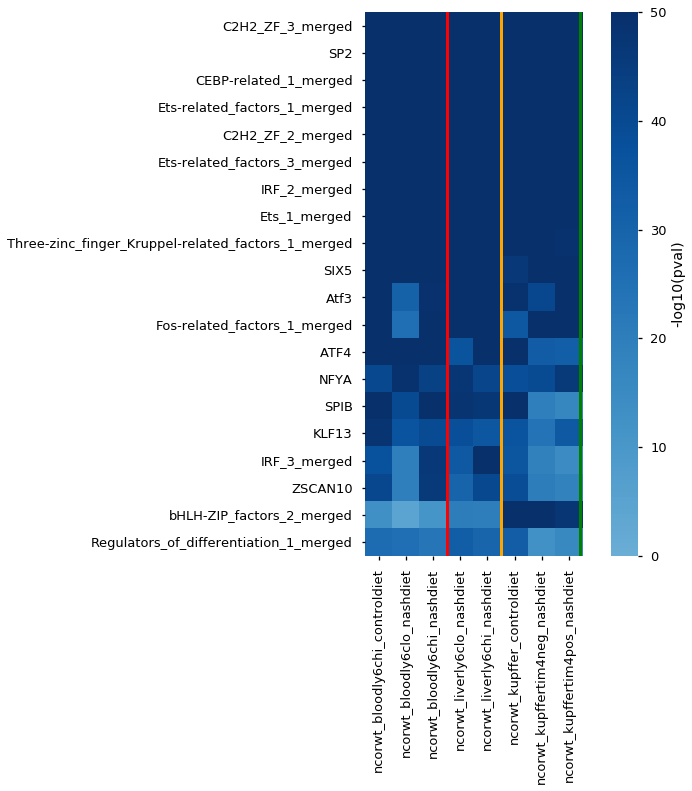

In [12]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

frame = frame.iloc[:20, :].loc[:, samp_order]
# frame = frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(
    frame,
    center=0,
    vmin=0,
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    cmap='Blues',
    ax=ax)
pos = hm.get_position()

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.9, 7.9], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_top20_motif_heatmap.pdf',bbox_inches='tight')

### Create Heatmap of differential motifs

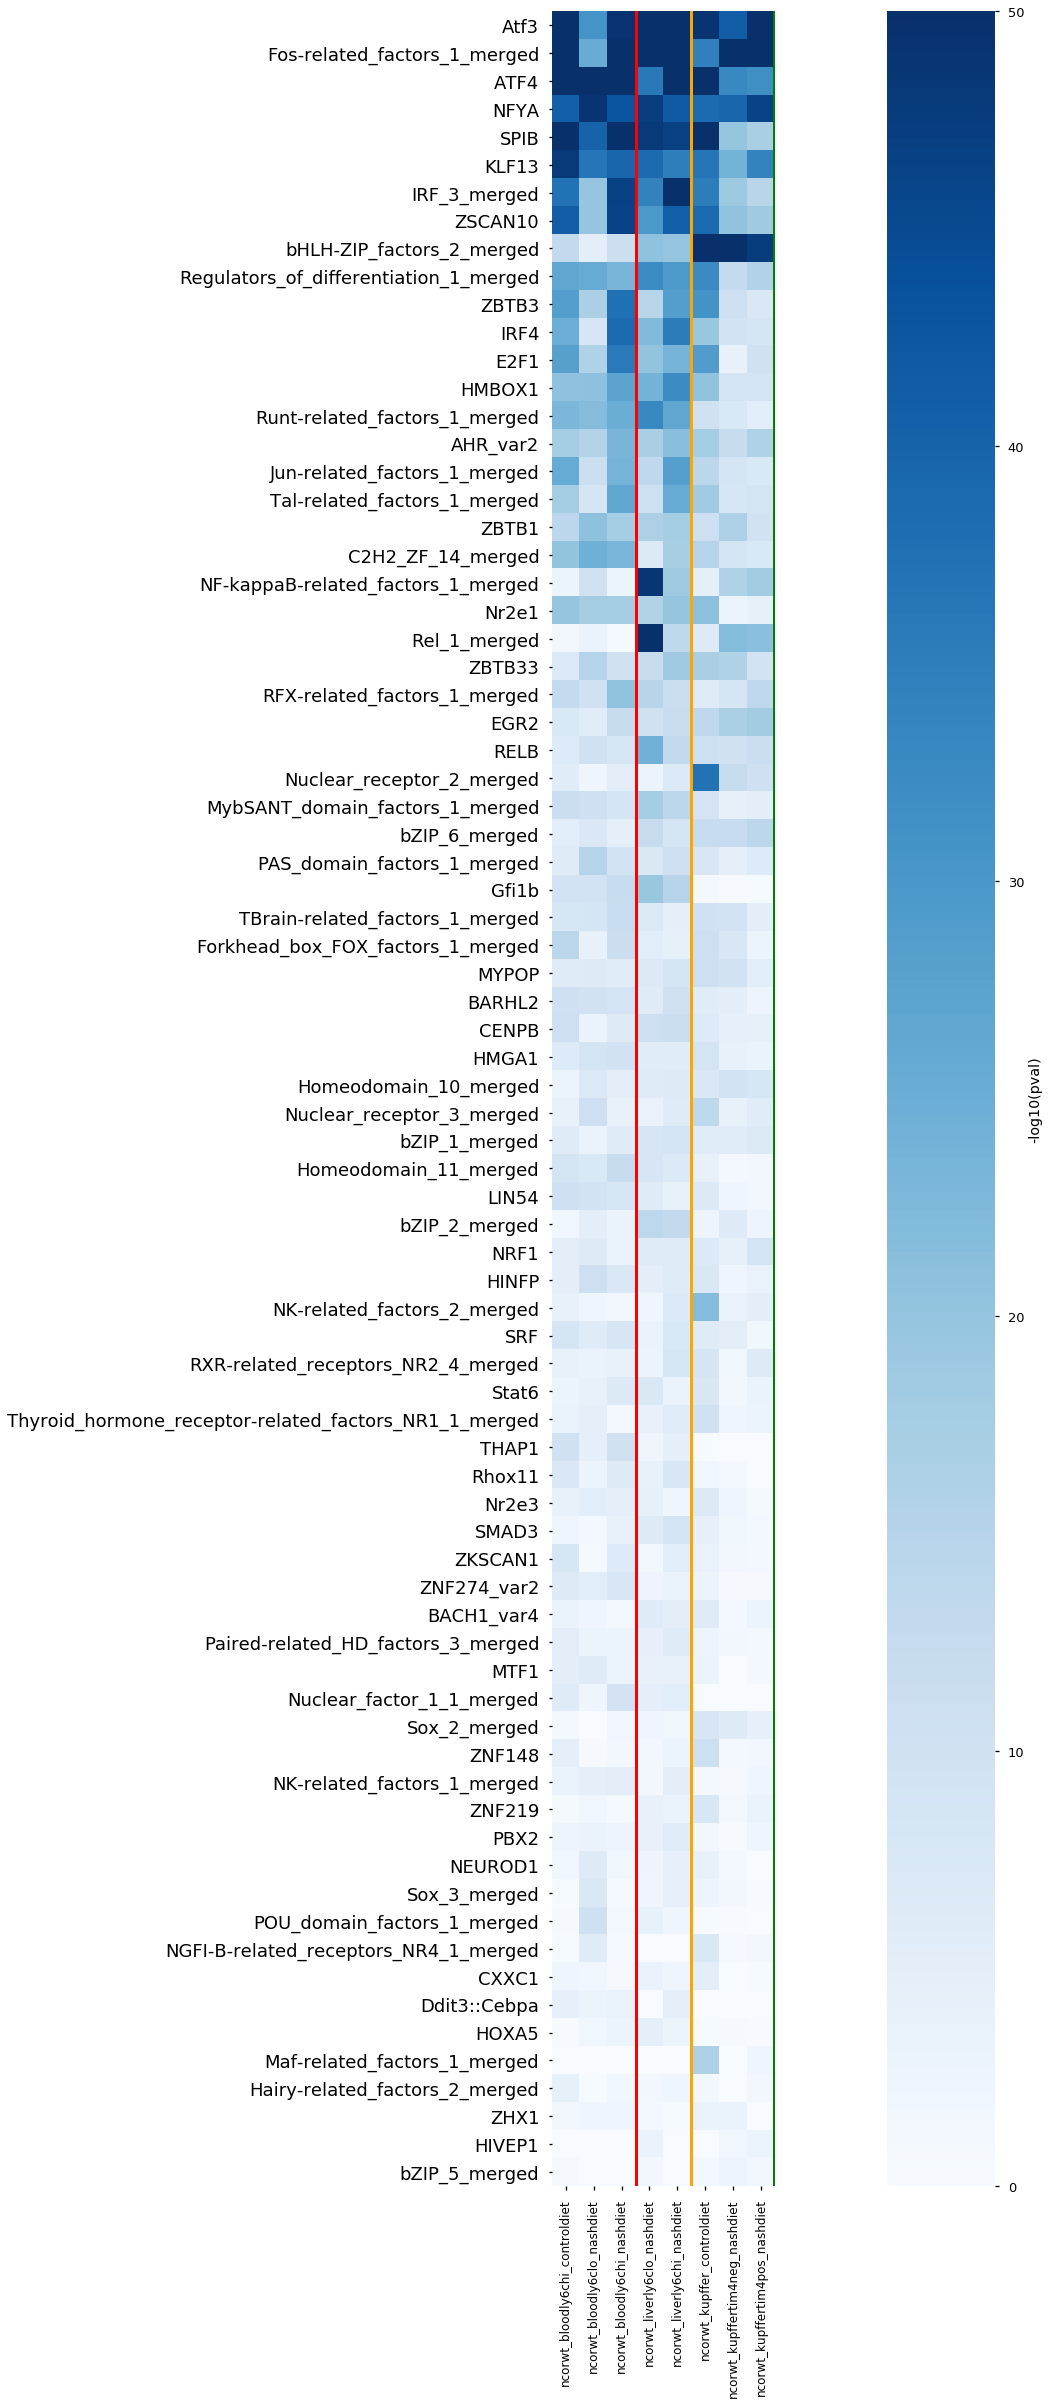

In [17]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    
# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Blues',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i[:100] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_differential_motif_heatmap_all_tfs.pdf',bbox_inches='tight')

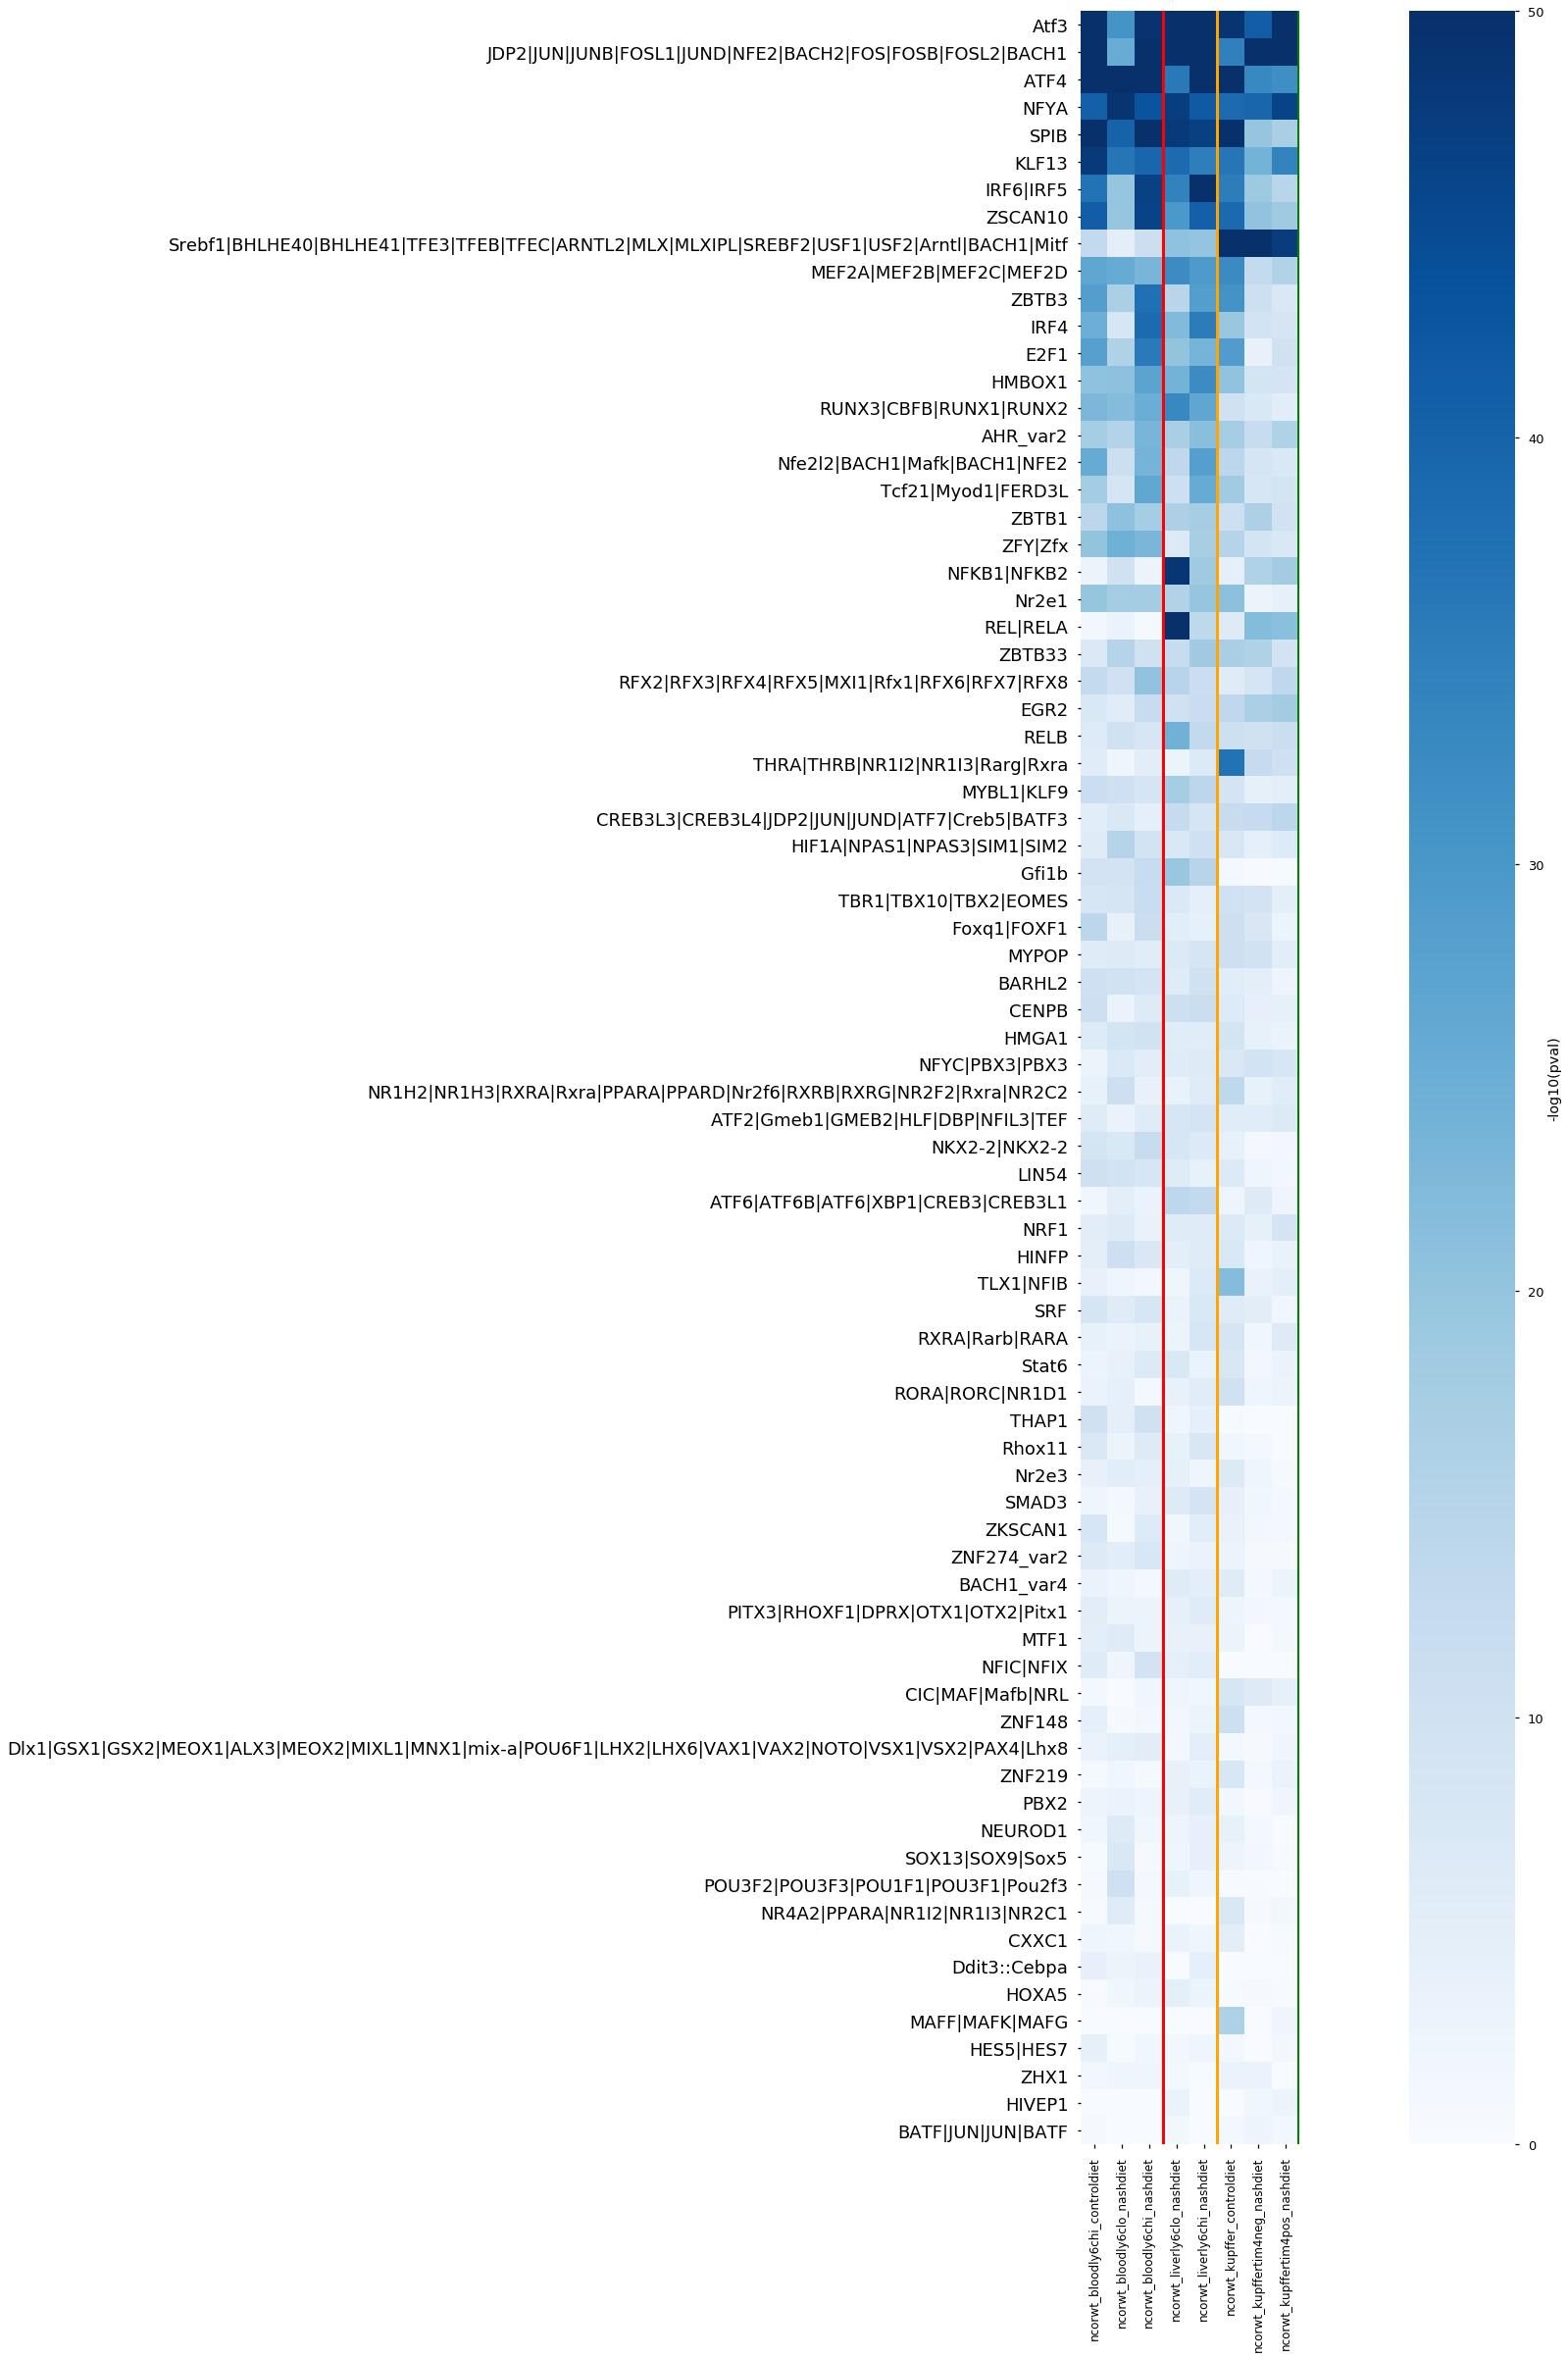

In [16]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]
filtered_frame = filtered_frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Blues',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i[:100] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');


plt.savefig('./figures/tba_differential_motif_heatmap.pdf',bbox_inches='tight')

## Compare HOMER Results to TBA

### Most apt comparison is the known motif analysis approach

In [12]:
%%bash
# delete the existing script file
rm ./run_knownmotif.sh
# create a script file
touch ./run_knownmotif.sh

# if directories don't exist, create them
if [ ! -d ./known_motif/ ]; then mkdir ./known_motif; fi

for peak_file in ./atac_idr_peaks/*;

do motif_file=${peak_file/atac_idr_peaks.tsv/known_motif_enrichment}
motif_file=${motif_file/atac_idr_peaks/known_motif}
echo "findMotifsGenome.pl $peak_file mm10 $motif_file -size 200 -nomotif &" >> run_knownmotif.sh
done

### Read in known motif significance values

In [13]:
known_motif_pval_dict = {}
for f in os.listdir('./known_motif/'):
#     with open('./known_motif/'+f+'/knownResults.txt', 'r') as j:
#         j.readline() # skip first line
#         pval = [fields[2] for fields in j.readlines()]
    
    # read in signifance values using pandas
    frame = pd.read_csv('./known_motif/'+f+'/knownResults.txt', sep='\t', index_col=0)
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 1]
    sample = '_'.join(f.split('_')[0:3])
    known_motif_pval_dict[sample] = pval
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

In [14]:
known_motif_pval_frame.head()

,ncorwt_bloodly6chi_controldiet,ncorwt_bloodly6chi_nashdiet,ncorwt_bloodly6clo_nashdiet,ncorwt_kupffer_controldiet,ncorwt_kupffertim4neg_nashdiet,ncorwt_kupffertim4pos_nashdiet,ncorwt_liverly6chi_nashdiet,ncorwt_liverly6clo_nashdiet
AMYB(HTH)/Testes-AMYB-ChIP-Seq(GSE44588)/Homer,1e-48,1e-38,1e-20,1e-12,1e-8,1e-12,1e-39,1e-22
AP-1(bZIP)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer,1e-800,1e-885,1e-329,1e-613,1e-784,1e-779,1e-1431,1e-1204
AP-2alpha(AP2)/Hela-AP2alpha-ChIP-Seq(GSE31477)/Homer,1e0,1e0,1e0,1e-1,1e0,1e0,1e0,1e0
AP-2gamma(AP2)/MCF7-TFAP2C-ChIP-Seq(GSE21234)/Homer,1e0,1e0,1e0,1e-2,1e0,1e0,1e0,1e0
AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer,1e0,1e0,1e0,1e0,1e0,1e0,1e0,1e0


### Top 20 by known motif

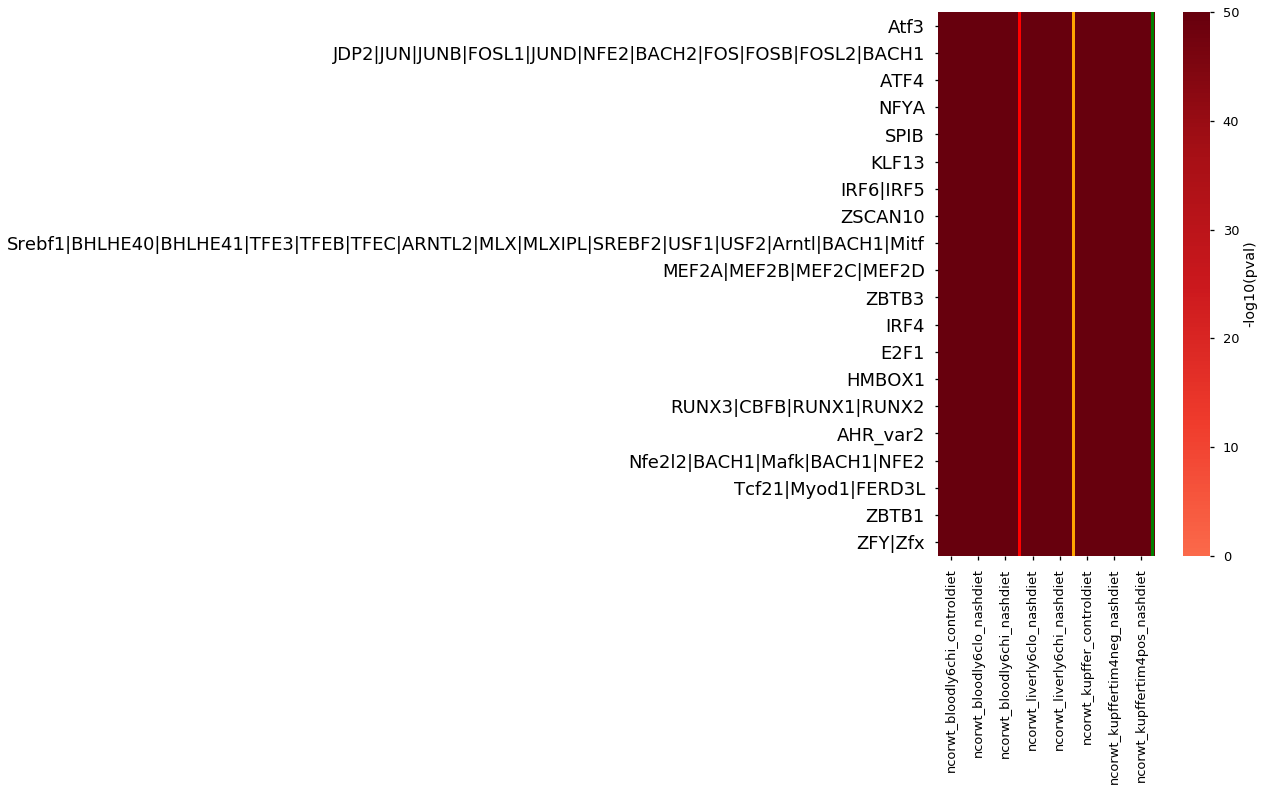

In [15]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = known_motif_pval_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(float(x)+pseudocount) for x in pvals]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = known_motif_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

frame = frame.iloc[:20, :].loc[:, samp_order]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(
    frame,
    center=0,
    vmin=0,
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    cmap='Reds',
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i.split('/')[0] for i in filtered_frame.index.values]);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.9, 7.9], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_top20_motif_heatmap.pdf',bbox_inches='tight')

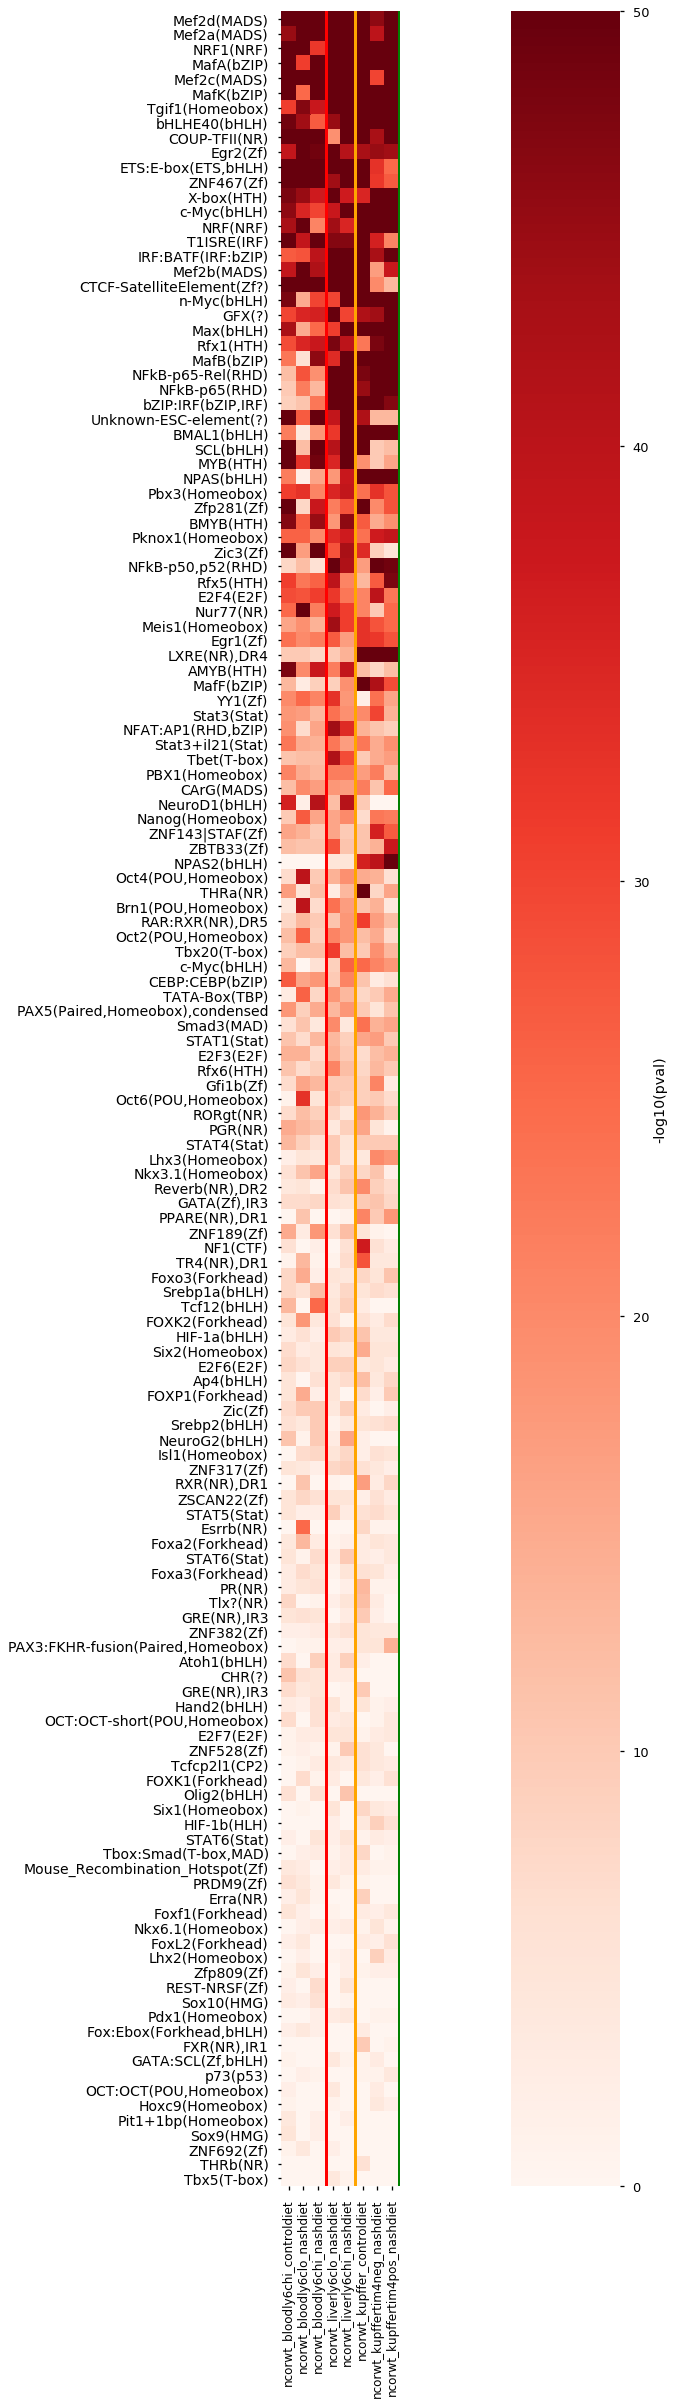

In [16]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = known_motif_pval_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(float(x)+pseudocount) for x in pvals]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = known_motif_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]
filtered_frame = filtered_frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Reds',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=14, labels = [i.split('/')[0] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 300], linewidth=3, color='r');
plt.plot([5, 5], [0, 300], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 300], linewidth=3, color='green');


plt.savefig('./figures/homer_differential_motif_heatmap_all_tfs.pdf',bbox_inches='tight')

### Run Get Differential Peaks

In [26]:
%%bash
# delete the existing script file
rm ./run_getDifferentialPeaks.sh
# create a script file
touch ./run_getDifferentialPeaks.sh

# if directories don't exist, create them
if [ ! -d ./diff_peaks/ ]; then mkdir ./diff_peaks; fi

In [27]:
import itertools
# write differential peaks and merge peaks commands
with open('./run_getDifferentialPeaks.sh', 'w') as f:
    # write differential peaks and merge peaks commands
    # merge peaks into one file
    f.write('mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_idr/ncorwt_atac_merged_peaks.tsv\n')
    # merge tag directories for getDifferential peaks
    mylist=rename_dict.keys()
    merged_peaks=[]
    for i, j in itertools.combinations(mylist, r=2):
        if (i.split('_ATAC')[0] == j.split('_ATAC')[0]):
            # create output file name for merging peaks
            out_file = [x for x in i.split('_') if x in set(j.split('_'))]
            out_file = '_'.join(out_file)+'_merged_tag_dir'
            merge_peaks = ['makeTagDirectory', './tag_directories_atac/'+out_file,
                           '-d', './tag_directories_atac/'+i,
                           './tag_directories_atac/'+j+'\n']
            f.write(' '.join(merge_peaks))
            merged_peaks.append(out_file)
            
    # run get differential peaks
    for i, j in itertools.combinations(merged_peaks, r=2):
        get_diff = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+j, 
                    './tag_directories_atac/'+i, '>',
                    './diff_peaks/'+j+'_vs_'+i+'_diffpeaks.tsv\n']
        get_diff_rev = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+i, 
                    './tag_directories_atac/'+j, '>',
                    './diff_peaks/'+i+'_vs_'+j+'_diffpeaks.tsv\n']
        f.write(' '.join(get_diff))
        f.write(' '.join(get_diff_rev))

In [28]:
# next up implement homer get differential motifs!

### we can also try finding motifs with just the distal atac peak files

In [29]:
# # table this for now - can use to switch to doing homer on distal peaks only
# %%bash
# # get distal peaks since we are mainly interested in enhancers
# for peak_file in ./atac_idr_peaks/*;
# do dist_file=${peak_file/.tsv/_distal.tsv};
# echo $dist_file
# getDistalPeaks.pl $peak_file mm10 > $dist_file;
# done

### Process denovo motif results and read into data frame for analysis

In [76]:
import codecs
# p values stored at the 9 + 8n cells
# names of TFs stored at the 13 + 8n cells
denovo_results = {}
for homerfile in os.listdir('./find_motifs/'):
    tf_logp_dict = {}
    tf_logp_dict_full = {}
    # open homer file
    if not (homerfile.startswith('.') | ('vs' in homerfile)) :
        f = codecs.open(
            './find_motifs/' + homerfile + '/homerResults.html', 'r')
        denovo = f.read().split('</TD><TD>')
        # table is in columns of 8
        # log p value is at position 9 + 8n
        # tf name is at position 13 + 8n
        for i in range(len(denovo) // 8):
            tf = denovo[13 + 8*i].split('/')[0]
            tf_2 = tf.split('(')[0]
            tf_logp_dict[tf_2] = denovo[9 + 8*i]
        denovo_results[homerfile] = tf_logp_dict
            
        
# create matrix of de novo motif log ps
denovo_logp = -pd.DataFrame(denovo_results, dtype=float).fillna(0)
# set max to 50 so its more comparable to tba
denovo_logp[denovo_logp > 50] = 50
# sort based on mean value
denovo_logp = denovo_logp.reindex(index=denovo_logp.mean(1).sort_values(ascending=False).index)

### Plot homer de novo motifs score with TBA on same heatmap

In [111]:
# manually adjust the labels of denovo logp so we can compare to jenhan's script
new_index = list(denovo_logp.index)
new_index[0]= 'bZIP_4_merged'
new_index[1]= 'CTCFL'
new_index[2]= 'related_factors_3_merged'
new_index[7]= 'FOSL1'
new_index[9]= 'RUNX1'
new_index[10]= 'E2F-related_factors_3_merged'
new_index[11]= 'GATA-type_zinc_fingers_1_merged'
new_index[12]= 'CEBP-related_1_merged'
new_index[13]= 'bHLH-ZIP_factors_2_merged'
new_index[14]= 'CREB-related_factors_1_merged'
new_index[16]= 'Jun-related_factors_2_merged'
new_index[17]= 'Three-zinc_finger_Kruppel-related_factors_4_merged'
new_index[18]= 'Regulators_of_differentiation_1_merged_2A'
new_index[19]= 'Regulators_of_differentiation_1_merged_2D'
new_index[20]= 'Rel_1_merged'
new_index[23]= 'MYBL1'
new_index[24]= 'type_homeo_domain_factors_2_merged'
new_index[25]= 'Homeodomain_15_merged'
new_index[27]= 'RFX-related_factors_1_merged'
new_index[28]= 'Runt-related_factors_1_merged'
new_index[30]= 'POU_domain_factors_2_merged'
new_index[31]= 'Homeodomain_9_merged'
new_index[32]= 'Nkx2-5'
new_index[33]= 'NF-kappaB-related_factors_1_merged'
new_index[34]= 'NFAT-related_factors_2_merged_C3'
new_index[35]= 'NFAT-related_factors_2_merged_5'
new_index[36]= 'Regulators_of_differentiation_1_merged_2Ab'
new_index[37]= 'related_factors_1_merged'
new_index[38]= 'related_factors_4_merged'
new_index[39]= 'Crx'
new_index[40]= 'SRF'

In [118]:
denovo_logp.index = new_index
merged_frame = denovo_logp.merge(filtered_frame, left_index=True,
                                 right_index=True, how='outer')
merged_frame = merged_frame.fillna(0)
merged_frame = merged_frame.reindex(
    index=merged_frame.mean(1).sort_values(ascending=False).index)

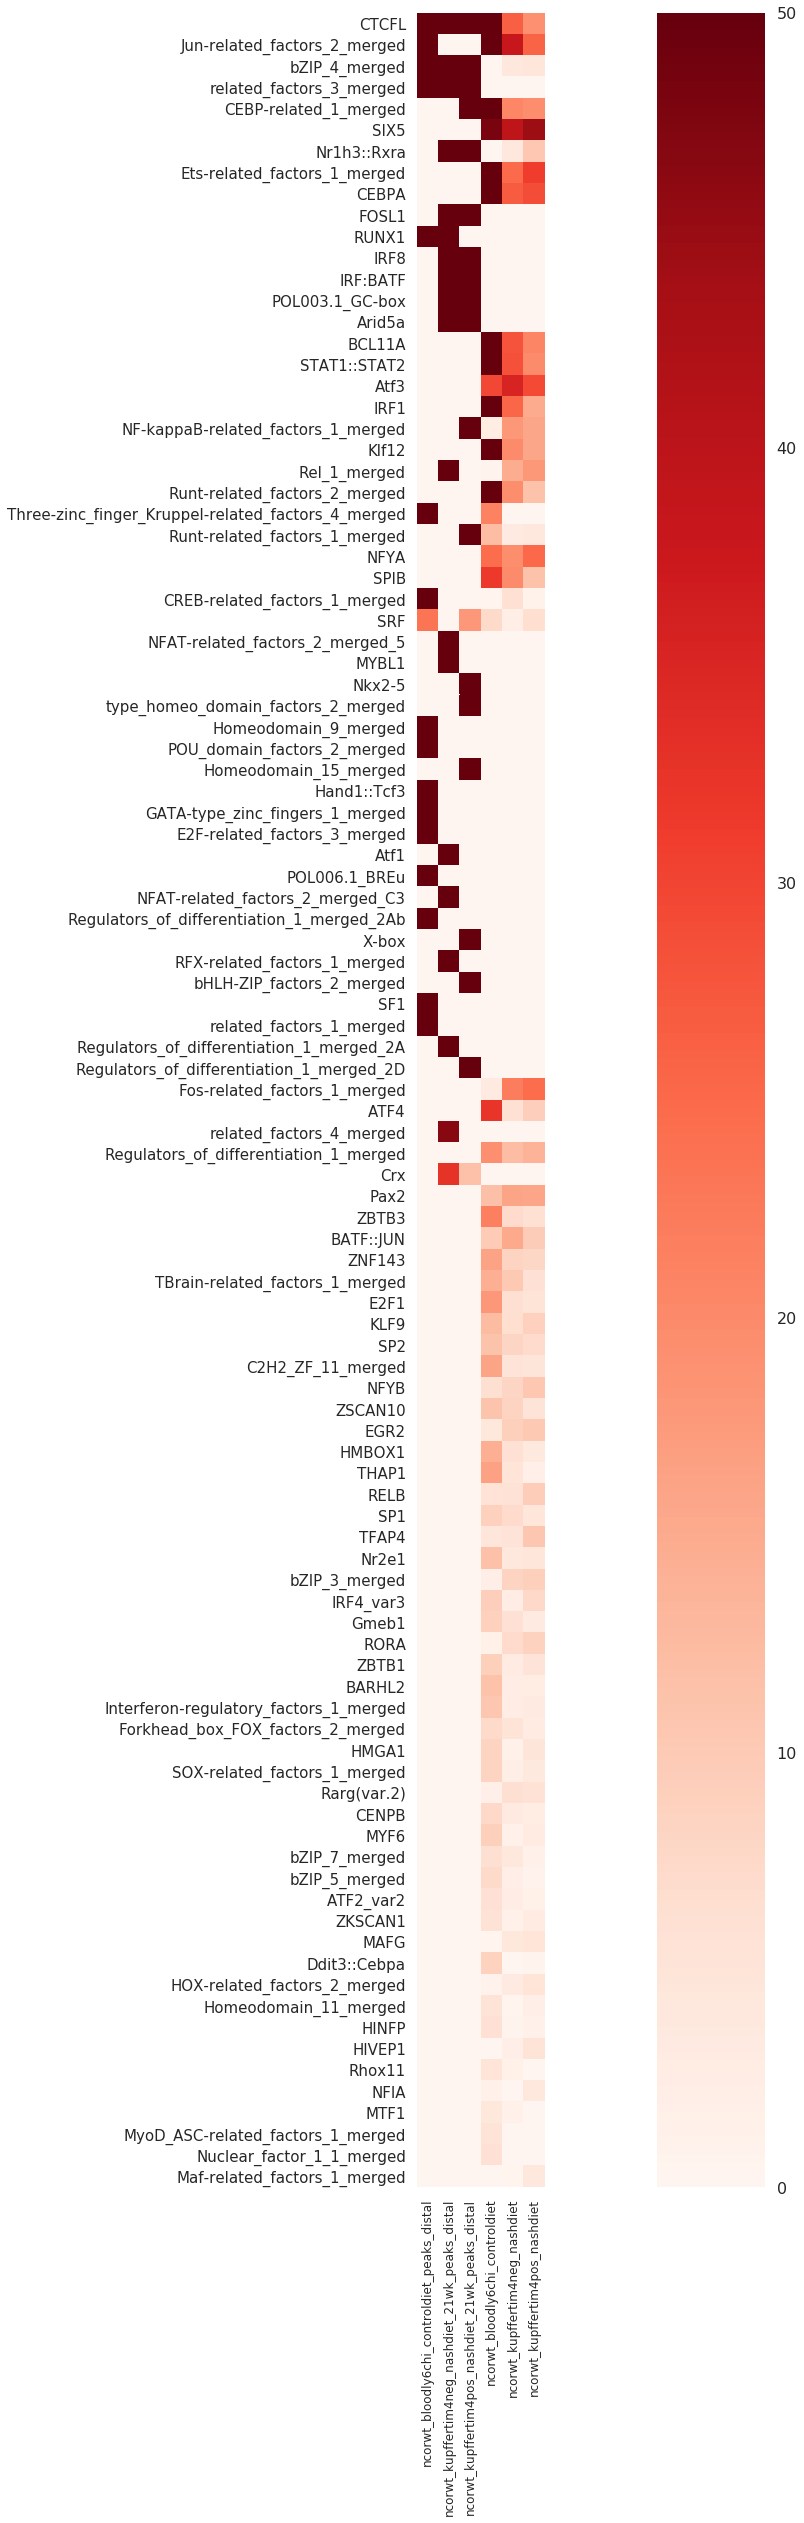

In [126]:
# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(merged_frame,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=15, labels = merged_frame.index.values);
hm.set_xticklabels(size=12, labels = merged_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap_homer_combined.pdf',bbox_inches='tight')

### Plot as subplots of same figure

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,20), sharey=False)
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax1)
pos = hm.get_position()

hm.set_yticks(range(0, filtered_frame.shape[0]));
hm.set_yticklabels(size=8, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

hm2 = sns.heatmap(denovo_logp,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax2)
pos = hm2.get_position()

hm2.set_yticks(range(0, denovo_logpy.shape[0]));
hm2.set_yticklabels(size=8, labels = denovo_logp.index.values,
                    verticalalignment='top');
hm2.set_xticklabels(size=12, labels = denovo_logp.columns.values, rotation=90);

### Plot Data

In [53]:
# import linear regression module
import statsmodels.formula.api as sm

# define function for labeling points on scatter
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=10)

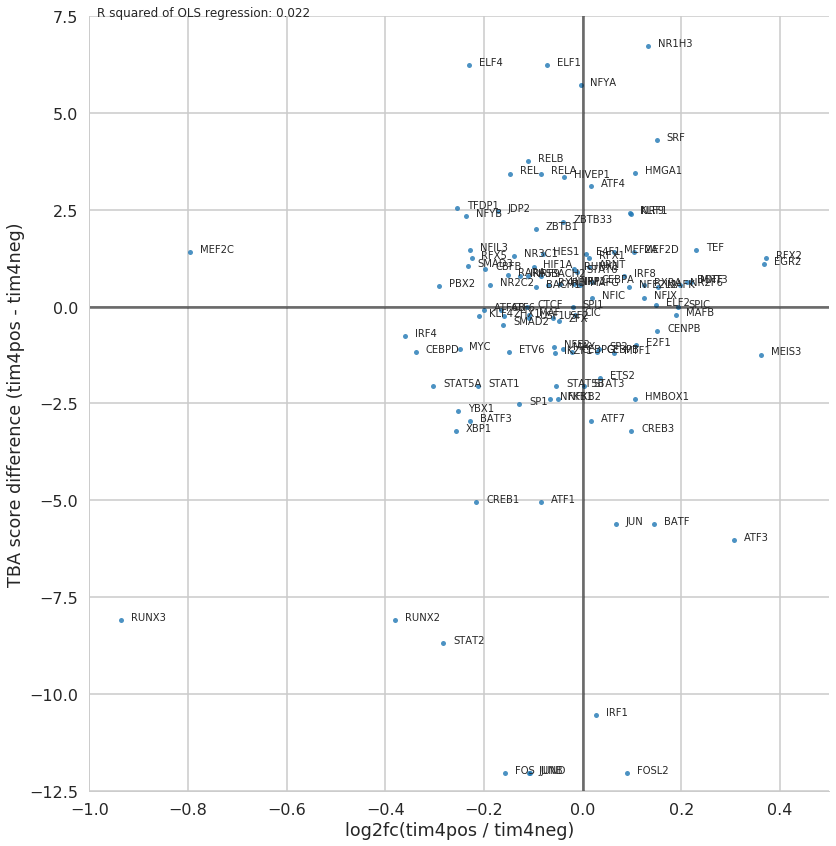

In [138]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet'
samp2 = 'ncorwt_kupffertim4neg_nashdiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / tim4neg)', 'TBA score difference (tim4pos - tim4neg)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-1,0.5])
axes.set_ylim([-12.5,7.5])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4pos_tim4neg_log_log_plot.pdf', bbox_inches='tight')

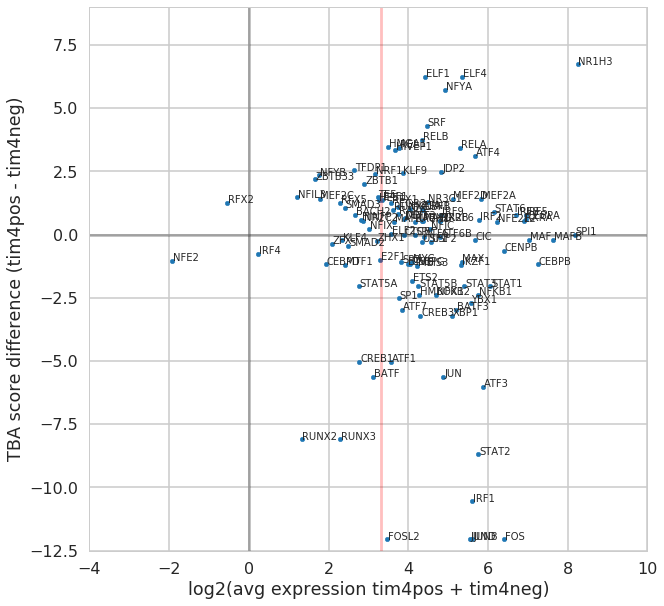

In [128]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + tim4neg)')
plt.ylabel('TBA score difference (tim4pos - tim4neg)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-4,10])
axes.set_ylim([-12.5,9])

plt.savefig('./expression/tim4pos_tim4neg_MAplot.pdf', bbox_inches='tight')

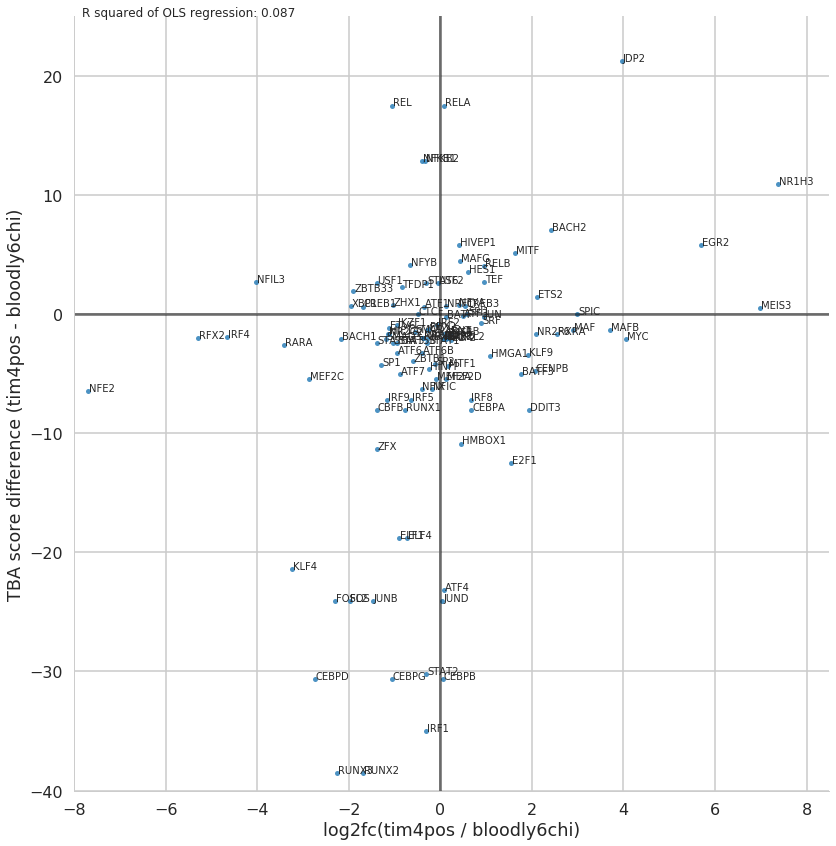

In [140]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet'
samp2 = 'ncorwt_bloodly6chi_controldiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / bloodly6chi)', 'TBA score difference (tim4pos - bloodly6chi)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-8,8.5])
axes.set_ylim([-40,25])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4pos_bloodly6chi_log_log_plot.pdf', bbox_inches='tight')

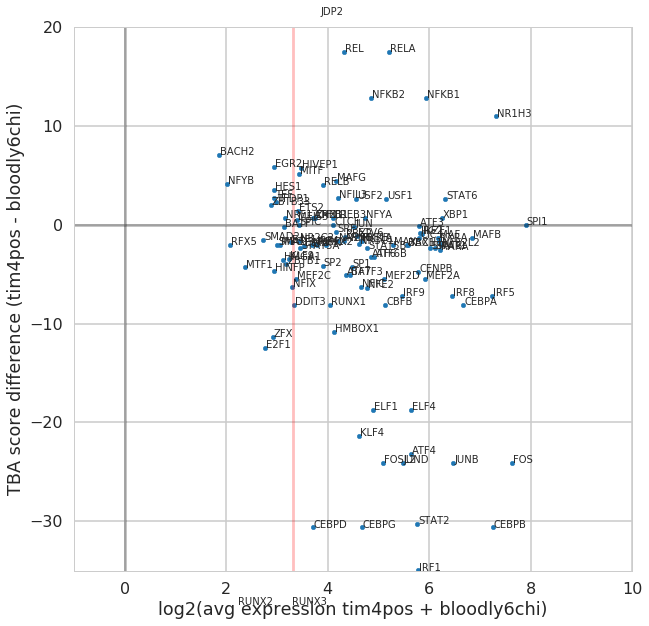

In [130]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + bloodly6chi)')
plt.ylabel('TBA score difference (tim4pos - bloodly6chi)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4pos_bloodly6chi_MAplot.pdf', bbox_inches='tight')

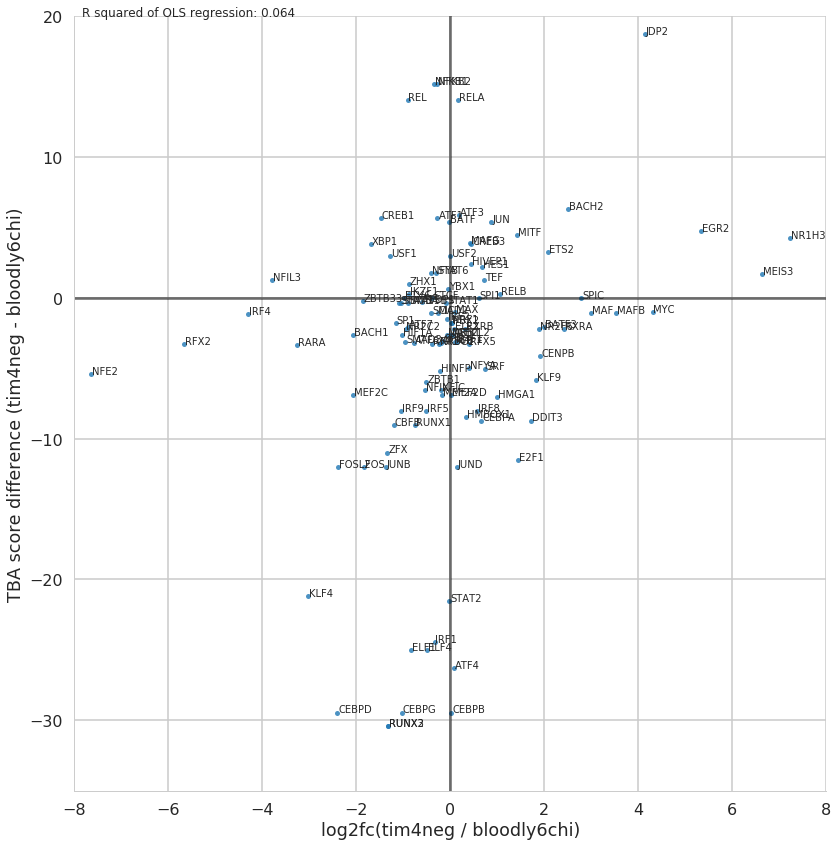

In [141]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet'
samp2 = 'ncorwt_bloodly6chi_controldiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg / bloodly6chi)', 'TBA score difference (tim4neg - bloodly6chi)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-8,8])
axes.set_ylim([-35,20])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4neg_bloodly6chi_log_log_plot.pdf', bbox_inches='tight')

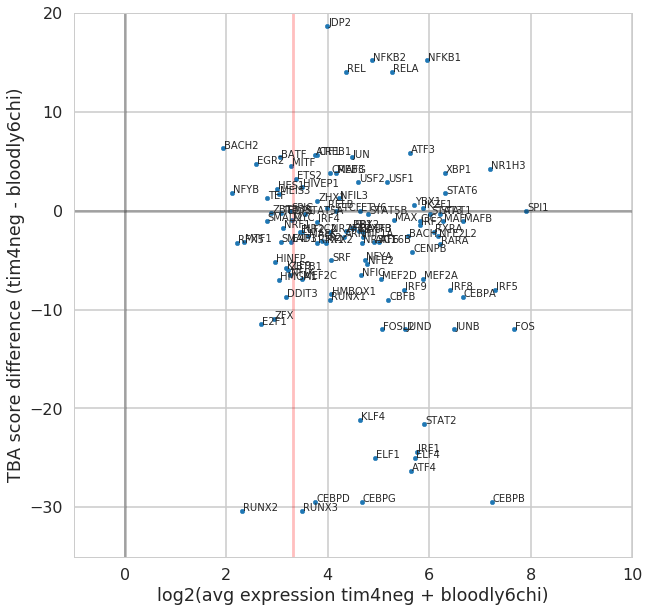

In [132]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg + bloodly6chi)')
plt.ylabel('TBA score difference (tim4neg - bloodly6chi)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4neg_bloodly6chi_MAplot.pdf', bbox_inches='tight')

### Create Table of top positively correlated motifs

In [377]:
pval_threshold = 1e-10
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
# positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,Motif,Mean p-val
CTCF,CTCF,1.000000e-50
Klf12,Klf12,1.000000e-50
Ets-related_1_merged,Ets-related_1_merged,1.000000e-50
IRF1,IRF1,1.000000e-50
Ets-related_2_merged,Ets-related_2_merged,1.000001e-50
STAT1::STAT2,STAT1::STAT2,3.012751e-49
Atf3,Atf3,4.758546e-48
Gabpa,Gabpa,1.042895e-47
NFYA,NFYA,4.740630e-30
Pax2,Pax2,2.150195e-29
